# Commands
Do female characters to use fewer commands than male characters? Does this depend on their role in the story? And do the TYPES of commands they use differ?

Below, I use regular expressions to capture 3 types of commands:
* Imperative Forms (ex: Stay here!)
* Modal Forms (ex: You must stay.)
* Suggestions (ex: You should stay.)

The lasts one, suggestion, isn't quite a command, but if we assume that female speech tends to be collaborative and noncombative, female speakers may lean more toward suggestion than male characters do.

In [1]:
import pandas as pd
import re

In [2]:
from matplotlib import pyplot as plt

In [3]:
from scipy import stats

In [4]:
movies_df = pd.read_pickle(r"C:/Users/cassi/Desktop/Data_Science/Animated-Movie-Gendered-Dialogue/private/all_tagged_dialogue.pkl")

In [5]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13442 entries, 0 to 13441
Data columns (total 19 columns):
Disney_Period       13442 non-null object
Gender              13442 non-null object
Movie               13442 non-null object
Role                13442 non-null object
Song                13442 non-null object
Speaker             13442 non-null object
Speaker_Status      13442 non-null object
Text                13442 non-null object
UTTERANCE_NUMBER    13442 non-null int64
Year                13442 non-null int64
Tokens              13442 non-null object
Types               13442 non-null object
Token_Count         13442 non-null int64
Type_Count          13442 non-null int64
POS                 13442 non-null object
Tag_Freq            13442 non-null object
Adj_Count           13442 non-null int64
Adv_Count           13442 non-null int64
Adj_over_Tokens     13442 non-null float64
dtypes: float64(1), int64(6), object(12)
memory usage: 1.3+ MB


## Finding Commands

### 1. Imperatives
The following function is based on the idea that commands come at the beginning of a sentence, and imperative commands are in the verb's base form ('VB' in my POS tags). So, first it checks if the first word is a base form verb, then it goes through the line and checks for a 'VB' after punctuation or a conjunction (so if someone says somethine like "Clean this up and do your homework", both commands will be captured).

In [6]:
def find_commands(tagged_sent):
    commands_count = 0
    if tagged_sent[0][1] == 'VB':
        commands_count += 1
    for x in tagged_sent[1:]:
        if x[1] == 'VB':
            place = tagged_sent.index(x)
            if tagged_sent[place-1][1] == "." or tagged_sent[place-1][1] == "," or tagged_sent[place-1][1] == 'CC':
                commands_count += 1
    return commands_count

In [7]:
movies_df["Imp_Command_Count"] = movies_df.POS.map(find_commands)

In [8]:
movies_df.Imp_Command_Count.describe() #most lines aren't commmands at all!

count    13442.000000
mean         0.198482
std          0.525834
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: Imp_Command_Count, dtype: float64

In [9]:
movies_df[movies_df.Imp_Command_Count >=1].shape

(2111, 20)

### 2. Modal Commands
Here, I look for modals addressed toward the second person. I exclude stuff like "You've gotta be kidding me".

In [10]:
def find_modal_commands(sent):
    m_commands_1 = re.findall(r"you( must| got to|'ve got to| gotta|'ve gotta)(?! be )", sent)
    m_commands_2 = re.findall(r"you (shall|will|have to|ought|need to|may not|can't|cannot|won't)", sent)
    m_commands_count = len(m_commands_1) + len(m_commands_2)
    return m_commands_count

In [11]:
movies_df['Modal_Command_Count'] = movies_df.Text.map(find_modal_commands)

In [12]:
movies_df['Modal_Command_Count'].describe() #not many....

count    13442.000000
mean         0.018822
std          0.145931
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: Modal_Command_Count, dtype: float64

In [13]:
movies_df[movies_df.Modal_Command_Count >=1].shape

(237, 21)

### 3. Suggestions
Here, I look for modals that imply suggestion. Notice how "you can come over" is more suggestive than "you can't come over", which sounds more like a blatant command.

In [14]:
def find_suggestion(sent):
    sug_1 = re.findall(r'you may (?!be )', sent)
    sug_2 = re.findall(r'you (should|could|better|can )', sent)
    sug_count = len(sug_1) + len(sug_2)
    return sug_count

In [15]:
movies_df['Suggestion_Count'] = movies_df.Text.map(find_suggestion)

In [16]:
movies_df.Suggestion_Count.describe() #again, not many...

count    13442.000000
mean         0.014804
std          0.123213
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: Suggestion_Count, dtype: float64

In [17]:
movies_df[movies_df.Suggestion_Count >=1].shape

(195, 22)

Overall, modal commands and suggestions are much less frequent than imperative commands. So, how do they compare?

### 4. Summing Them All Up
Let's add all these values to get a cumulative command count!

In [18]:
movies_df['Total_Command_Count'] = movies_df.Imp_Command_Count + movies_df.Modal_Command_Count + movies_df.Suggestion_Count

In [19]:
movies_df.Total_Command_Count.describe()

count    13442.000000
mean         0.232108
std          0.572789
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         12.000000
Name: Total_Command_Count, dtype: float64

In [20]:
movies_df[movies_df.Total_Command_Count == 12].iloc[0].Text

"i am moana of motunui. you will board my boat, sail across the sea, and restore the heart of te fiti. i am moana…of motu--nui. heihei? it’s okay. it's alright. see? there we go. nice water. the ocean is a friend of mine. heihei? heihei! stay. okay, next stop, maui. i am moana of motunui. you will board my boat, sail across the sea, and restore of te fiti. i am moana of ... board my boat! oh no. no, no, no! uh, ocean? can i get a little help? no, no. please. come on! help me! please!"

## Visualizations
### Gender

In [21]:
movies_gen_df = movies_df[movies_df.Gender != 'n']

Text(0, 0.5, 'Command Count')

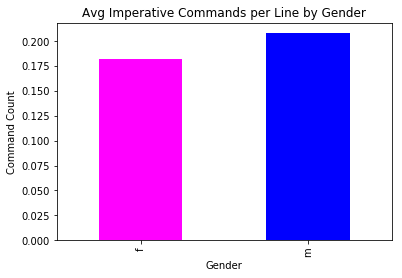

In [22]:
imp_command_by_gen = movies_gen_df.groupby('Gender')['Imp_Command_Count'].describe()['mean']
imp_command_by_gen.plot.bar(color=['magenta', 'blue'])
plt.title('Avg Imperative Commands per Line by Gender')
plt.ylabel('Command Count')

Text(0, 0.5, 'Command Count')

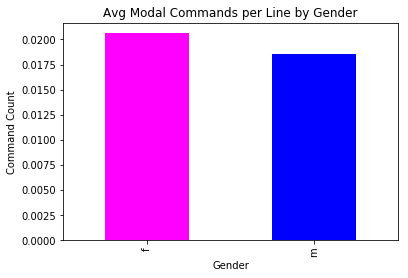

In [23]:
mod_command_by_gen = movies_gen_df.groupby('Gender')['Modal_Command_Count'].describe()['mean']
mod_command_by_gen.plot.bar(color=['magenta', 'blue'])
plt.title('Avg Modal Commands per Line by Gender')
plt.ylabel('Command Count')

Text(0, 0.5, 'Suggestion Count')

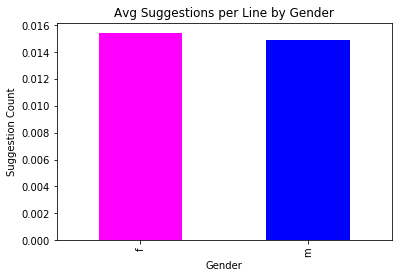

In [24]:
sug_by_gen = movies_gen_df.groupby('Gender')['Suggestion_Count'].describe()['mean']
sug_by_gen.plot.bar(color=['magenta', 'blue'])
plt.title('Avg Suggestions per Line by Gender')
plt.ylabel('Suggestion Count')

It looks like males use more imperatives, while females are more inclined to use modals or suggestion!

Text(0, 0.5, 'Command Count')

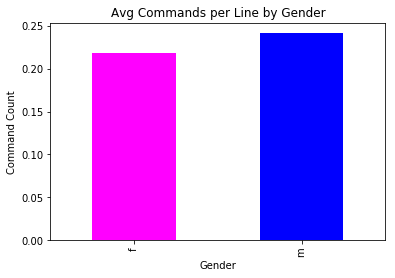

In [39]:
com_by_gen = movies_gen_df.groupby('Gender')['Total_Command_Count'].describe()['mean']
com_by_gen.plot.bar(color=['magenta', 'blue'])
plt.title('Avg Commands per Line by Gender')
plt.ylabel('Command Count')

Text(0.5, 1.0, 'Avg Imperative Command Counts Over Time by Gender')

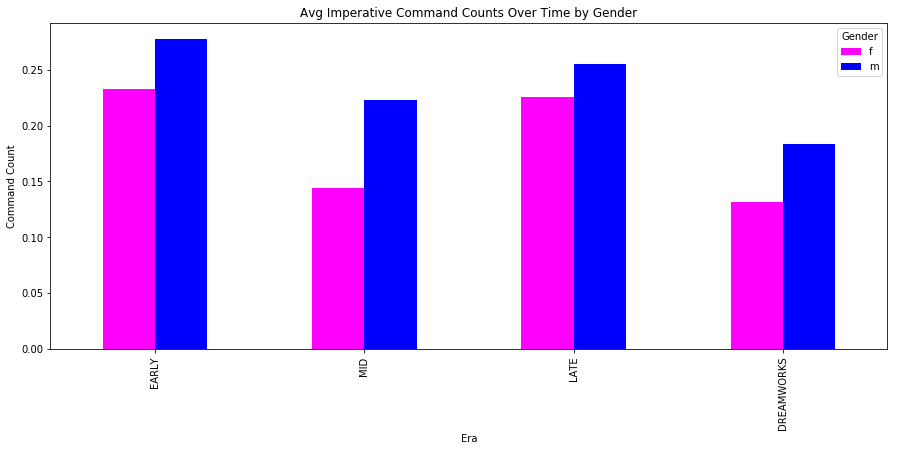

In [25]:
imp_com_by_gen_era = movies_gen_df.groupby(['Disney_Period','Gender'], sort=False)['Imp_Command_Count'].describe()['mean']
imp_com_by_gen_era.unstack().plot.bar(color=['magenta', 'blue'], figsize=(15,6))
plt.xlabel('Era')
plt.ylabel('Command Count')
plt.title('Avg Imperative Command Counts Over Time by Gender')

Males consistently have more imperative commands in each era.

Text(0.5, 1.0, 'Avg Modal Command Counts Over Time by Gender')

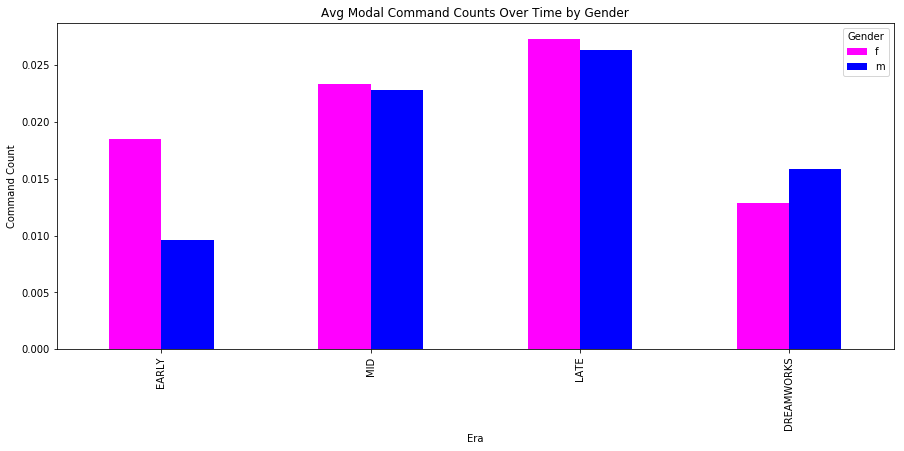

In [26]:
mod_com_by_gen_era = movies_gen_df.groupby(['Disney_Period','Gender'], sort=False)['Modal_Command_Count'].describe()['mean']
mod_com_by_gen_era.unstack().plot.bar(color=['magenta', 'blue'], figsize=(15,6))
plt.xlabel('Era')
plt.ylabel('Command Count')
plt.title('Avg Modal Command Counts Over Time by Gender')

In every era (save dreamworks), females use more modal commands than males, and both genders have increased their modal command count

Text(0.5, 1.0, 'Avg Suggestion Counts Over Time by Gender')

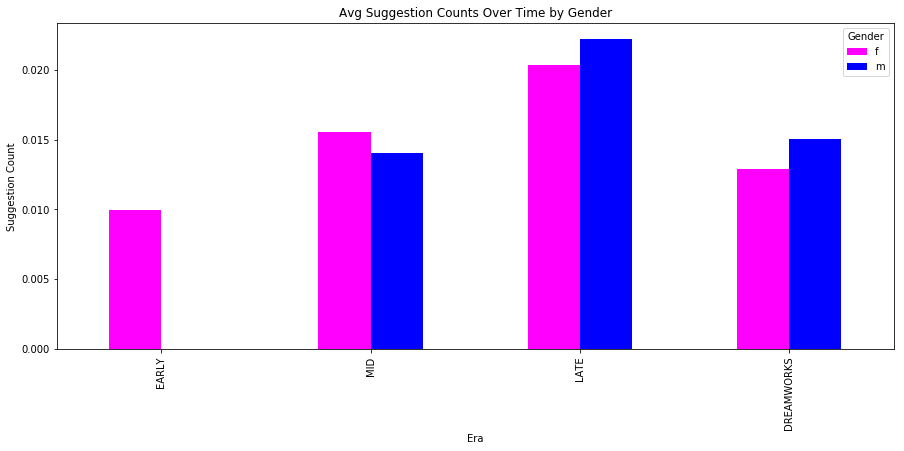

In [27]:
sug_by_gen_era = movies_gen_df.groupby(['Disney_Period','Gender'], sort=False)['Suggestion_Count'].describe()['mean']
sug_by_gen_era.unstack().plot.bar(color=['magenta', 'blue'], figsize=(15,6))
plt.xlabel('Era')
plt.ylabel('Suggestion Count')
plt.title('Avg Suggestion Counts Over Time by Gender')

No male characters make suggestions in the early period! This may be a reflection of my regular expressions...

Text(0.5, 1.0, 'Avg Total Command Counts Over Time by Gender')

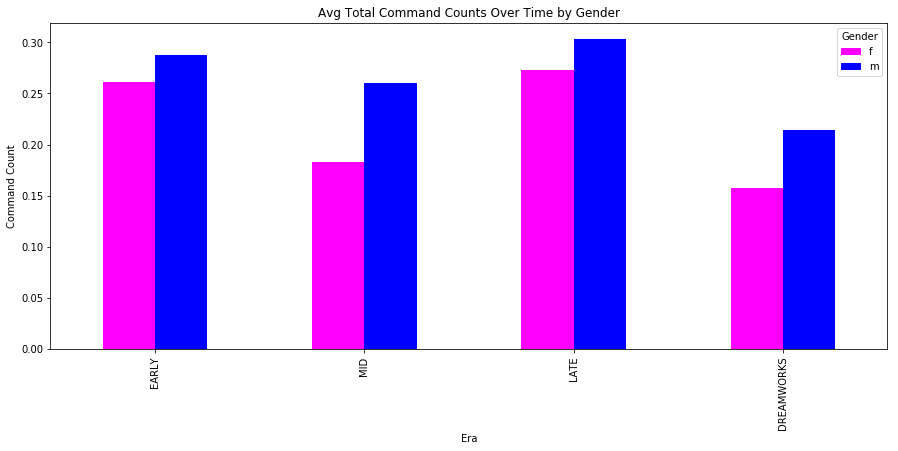

In [40]:
com_by_gen_era = movies_gen_df.groupby(['Disney_Period','Gender'], sort=False)['Total_Command_Count'].describe()['mean']
com_by_gen_era.unstack().plot.bar(color=['magenta', 'blue'], figsize=(15,6))
plt.xlabel('Era')
plt.ylabel('Command Count')
plt.title('Avg Total Command Counts Over Time by Gender')

### Role

In [28]:
movies_role_df = movies_df[movies_df.Role != 'N']

Text(0, 0.5, 'Command Count')

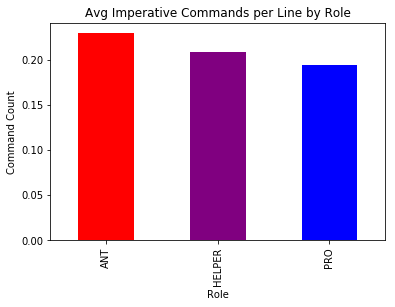

In [29]:
imp_command_by_role = movies_role_df.groupby('Role')['Imp_Command_Count'].describe()['mean']
imp_command_by_role.plot.bar(color=['red', 'purple', 'blue'])
plt.title('Avg Imperative Commands per Line by Role')
plt.ylabel('Command Count')

Text(0, 0.5, 'Command Count')

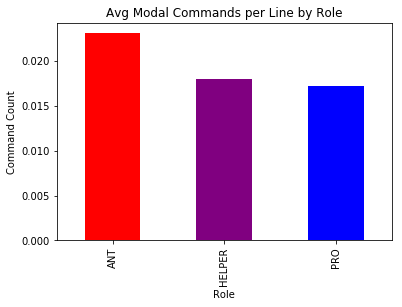

In [30]:
mod_command_by_role = movies_role_df.groupby('Role')['Modal_Command_Count'].describe()['mean']
mod_command_by_role.plot.bar(color=['red', 'purple', 'blue'])
plt.title('Avg Modal Commands per Line by Role')
plt.ylabel('Command Count')

Text(0, 0.5, 'Suggestion Count')

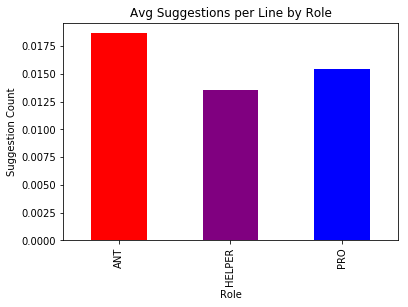

In [31]:
sug_by_role = movies_role_df.groupby('Role')['Suggestion_Count'].describe()['mean']
sug_by_role.plot.bar(color=['red', 'purple', 'blue'])
plt.title('Avg Suggestions per Line by Role')
plt.ylabel('Suggestion Count')

Antagonists seem to make more suggestions and commands!

Text(0, 0.5, 'Command Count')

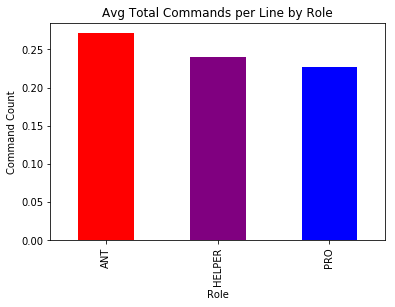

In [41]:
com_by_role = movies_role_df.groupby('Role')['Total_Command_Count'].describe()['mean']
com_by_role.plot.bar(color=['red', 'purple', 'blue'])
plt.title('Avg Total Commands per Line by Role')
plt.ylabel('Command Count')

Text(0, 0.5, 'Command Count')

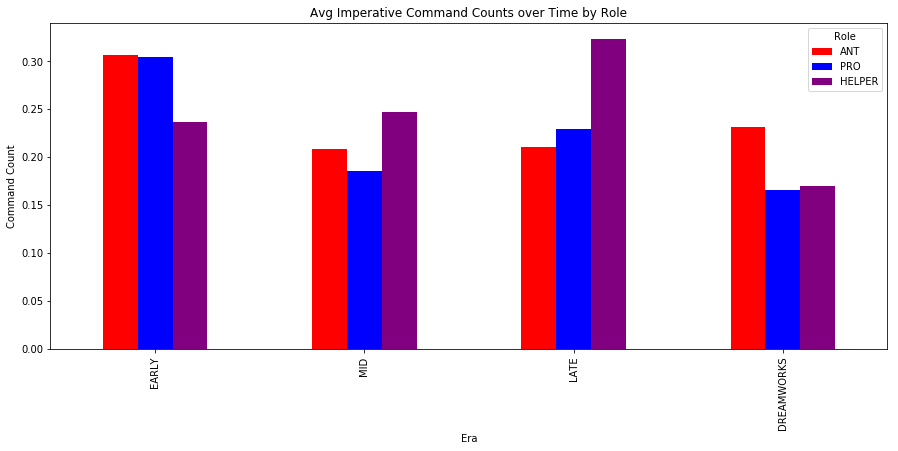

In [32]:
imp_com_by_role_era = movies_role_df.groupby(['Disney_Period','Role'], sort=False)['Imp_Command_Count'].describe()['mean']
imp_com_by_role_era.unstack().plot.bar(color=['red', 'blue', 'purple'], figsize=(15,6))
plt.title('Avg Imperative Command Counts over Time by Role')
plt.xlabel('Era')
plt.ylabel('Command Count')

This is pretty mixed...

Text(0, 0.5, 'Command Count')

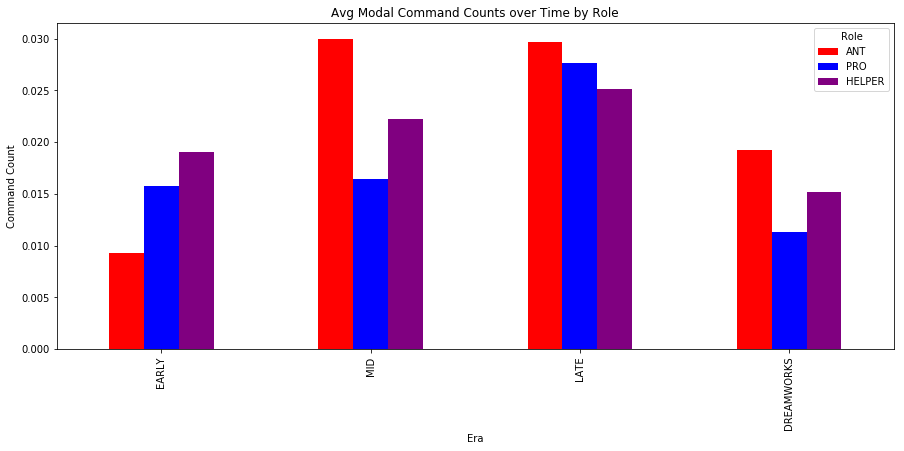

In [33]:
mod_com_by_role_era = movies_role_df.groupby(['Disney_Period','Role'], sort=False)['Modal_Command_Count'].describe()['mean']
mod_com_by_role_era.unstack().plot.bar(color=['red', 'blue', 'purple'], figsize=(15,6))
plt.title('Avg Modal Command Counts over Time by Role')
plt.xlabel('Era')
plt.ylabel('Command Count')

As time goes on, both protagonists and antagonists tend to use more modal commands

Text(0, 0.5, 'Suggestion Count')

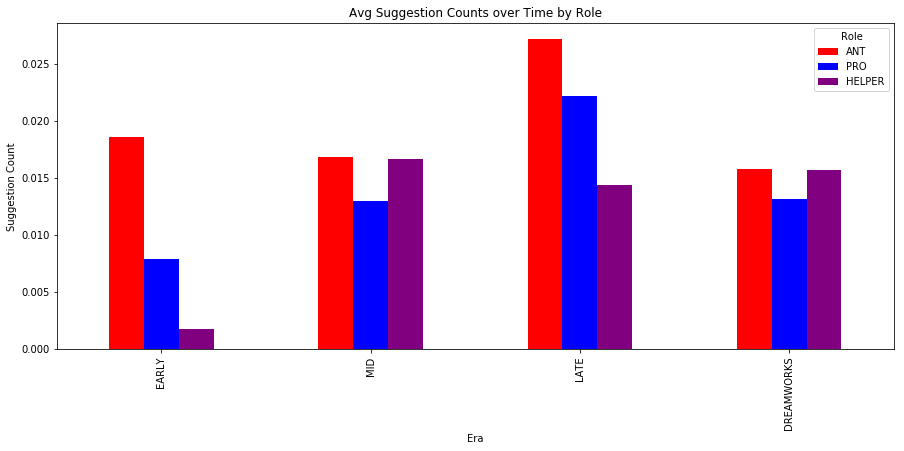

In [34]:
sug_by_role_era = movies_role_df.groupby(['Disney_Period','Role'], sort=False)['Suggestion_Count'].describe()['mean']
sug_by_role_era.unstack().plot.bar(color=['red', 'blue', 'purple'], figsize=(15,6))
plt.title('Avg Suggestion Counts over Time by Role')
plt.xlabel('Era')
plt.ylabel('Suggestion Count')

In each era, antagonists are making more suggestions--perhaps as a form of trickery? Protagonists have also increased suggestion counts over time

Text(0, 0.5, 'Command Count')

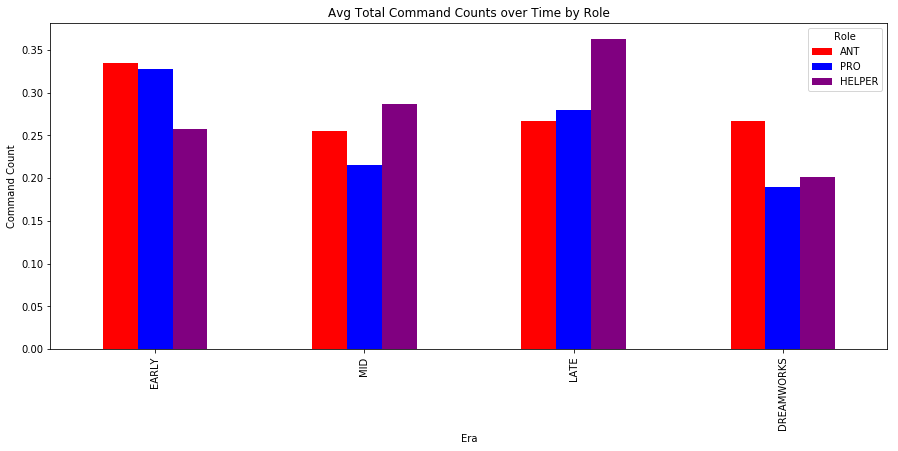

In [42]:
com_by_role_era = movies_role_df.groupby(['Disney_Period','Role'], sort=False)['Total_Command_Count'].describe()['mean']
com_by_role_era.unstack().plot.bar(color=['red', 'blue', 'purple'], figsize=(15,6))
plt.title('Avg Total Command Counts over Time by Role')
plt.xlabel('Era')
plt.ylabel('Command Count')

### Role and Gender


In [35]:
movies_role_gen_df = movies_df[(movies_df.Gender != 'n') & (movies_df.Role != 'N')]

Text(0, 0.5, 'Command Count')

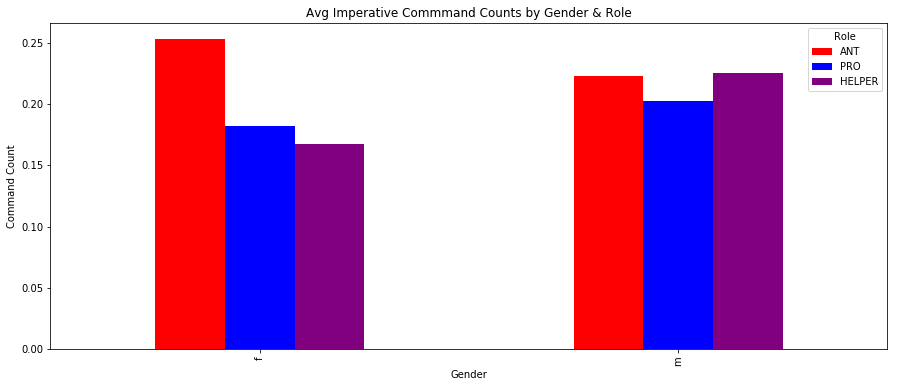

In [36]:
imp_com_gen_role = movies_role_gen_df.groupby(['Gender','Role'], sort=False)['Imp_Command_Count'].describe()['mean']
imp_com_gen_role.unstack().plot.bar(color=['red', 'blue', 'purple'], figsize=(15,6))
plt.title('Avg Imperative Commmand Counts by Gender & Role')
plt.xlabel('Gender')
plt.ylabel('Command Count')

Female antagonists use more commands than female protagonists and male antagonists. Male protagonists only use slightly more commands than female protagonists.

Text(0, 0.5, 'Command Count')

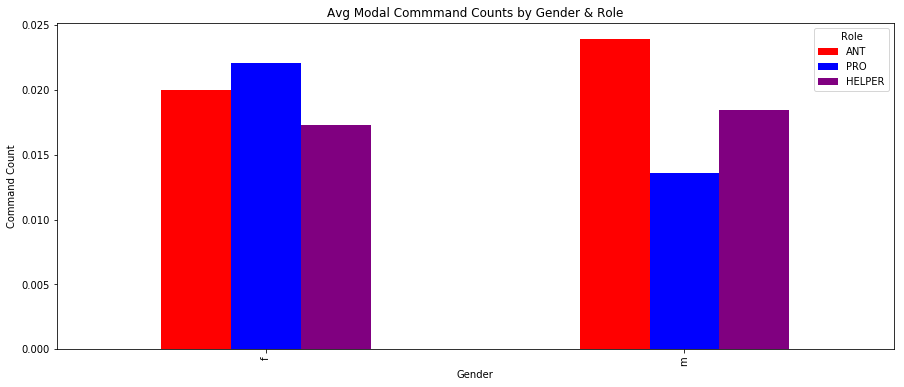

In [37]:
mod_com_gen_role = movies_role_gen_df.groupby(['Gender','Role'], sort=False)['Modal_Command_Count'].describe()['mean']
mod_com_gen_role.unstack().plot.bar(color=['red', 'blue', 'purple'], figsize=(15,6))
plt.title('Avg Modal Commmand Counts by Gender & Role')
plt.xlabel('Gender')
plt.ylabel('Command Count')

Female protagonists use more modal commands than male protagonists and female antagonists!

Text(0, 0.5, 'Suggestion Count')

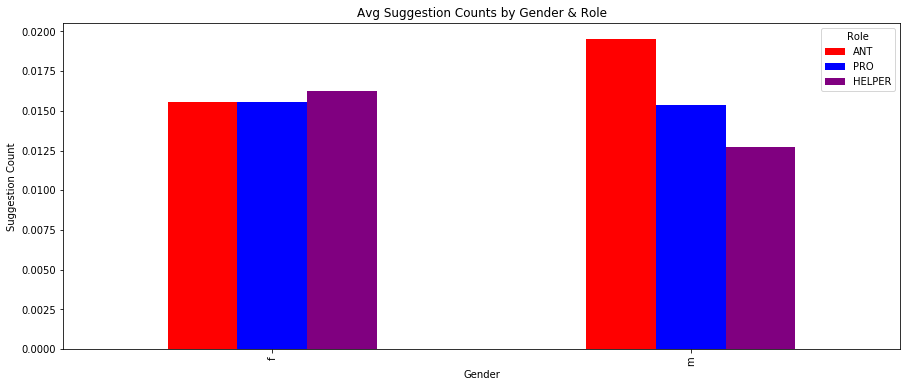

In [38]:
sug_gen_role = movies_role_gen_df.groupby(['Gender','Role'], sort=False)['Suggestion_Count'].describe()['mean']
sug_gen_role.unstack().plot.bar(color=['red', 'blue', 'purple'], figsize=(15,6))
plt.title('Avg Suggestion Counts by Gender & Role')
plt.xlabel('Gender')
plt.ylabel('Suggestion Count')

Wow, nearly no differences between female pros and ants or male pros and female pros. But male antagonists tend to use them.

## Significance Tests

In [43]:
#Gender overall
f_movies = movies_df[movies_df.Gender == 'f']
m_movies = movies_df[movies_df.Gender == 'm']

#Gender over time
f_movies_early = f_movies[f_movies.Disney_Period == 'EARLY']
m_movies_early = m_movies[m_movies.Disney_Period == 'EARLY']

f_movies_mid = f_movies[f_movies.Disney_Period == 'MID']
m_movies_mid = m_movies[m_movies.Disney_Period == 'MID']

f_movies_late = f_movies[f_movies.Disney_Period == 'LATE']
m_movies_late = m_movies[m_movies.Disney_Period == 'LATE']

#Gender Across Companies
f_movies_disney = f_movies[f_movies.Disney_Period != 'DREAMWORKS']
f_movies_dw = f_movies[f_movies.Disney_Period == 'DREAMWORKS']

m_movies_disney = m_movies[m_movies.Disney_Period != 'DREAMWORKS']
m_movies_dw = m_movies[m_movies.Disney_Period == 'DREAMWORKS']

#Role Overall
pro_movies = movies_df[movies_df.Role == 'PRO']
ant_movies = movies_df[movies_df.Role == 'ANT']
helper_movies = movies_df[movies_df.Role == 'HELPER']

#Role Over Time
pro_movies_early = pro_movies[pro_movies.Disney_Period == 'EARLY']
pro_movies_mid = pro_movies[pro_movies.Disney_Period == 'MID']
pro_movies_late = pro_movies[pro_movies.Disney_Period == 'LATE']

ant_movies_early = ant_movies[ant_movies.Disney_Period == 'EARLY']
ant_movies_mid = ant_movies[ant_movies.Disney_Period == 'MID']
ant_movies_late = ant_movies[ant_movies.Disney_Period == 'LATE']

#Role by Company
ant_movies_disney = ant_movies[ant_movies.Disney_Period != 'DREAMWORKS']
ant_movies_dw = ant_movies[ant_movies.Disney_Period == 'DREAMWORKS']

pro_movies_disney = pro_movies[pro_movies.Disney_Period != 'DREAMWORKS']
pro_movies_dw = pro_movies[pro_movies.Disney_Period == 'DREAMWORKS']

#Role and Gender
movies_gen_role = movies_df[(movies_df.Gender != 'n') & (movies_df.Role != 'N')]

pro_f_movies = movies_gen_role[(movies_gen_role.Gender == 'f') & (movies_gen_role.Role == 'PRO')]
pro_m_movies = movies_gen_role[(movies_gen_role.Gender == 'm') & (movies_gen_role.Role == 'PRO')]

ant_f_movies = movies_gen_role[(movies_gen_role.Gender == 'f') & (movies_gen_role.Role == 'ANT')]
ant_m_movies = movies_gen_role[(movies_gen_role.Gender == 'm') & (movies_gen_role.Role == 'ANT')]

### Gender
#### Gender Overall

In [47]:
print('Overall Gender Differences (Male vs Female)')
for x in ['Imp_Command_Count', 'Modal_Command_Count', 'Suggestion_Count', 'Total_Command_Count']:
    print(x)
    print(stats.ttest_ind(m_movies[x], f_movies[x], equal_var=False))
    print('\n')

Overall Gender Differences (Male vs Female)
Imp_Command_Count
Ttest_indResult(statistic=2.659776627954855, pvalue=0.007833837143633273)


Modal_Command_Count
Ttest_indResult(statistic=-0.7551096511463004, pvalue=0.4502058802815313)


Suggestion_Count
Ttest_indResult(statistic=-0.21147132614904182, pvalue=0.8325248644262484)


Total_Command_Count
Ttest_indResult(statistic=2.168885120953673, pvalue=0.03011967418309977)




Male characters use significantly more imperative commands, and overall use significantly more commands!

#### Gender Over Time

In [49]:
print('Gender Differences over Time')
for x in ['Imp_Command_Count', 'Modal_Command_Count', 'Suggestion_Count', 'Total_Command_Count']:
    print(x)
    print('Female')
    print('ANOVA')
    print(stats.f_oneway(f_movies_early[x], f_movies_mid[x], f_movies_late[x]))
    print('EARLY V MID')
    print(stats.ttest_ind(f_movies_early[x], f_movies_mid[x], equal_var=False))
    print('EARLY V LATE')
    print(stats.ttest_ind(f_movies_early[x], f_movies_late[x], equal_var=False))
    print('MID V LATE')
    print(stats.ttest_ind(f_movies_mid[x], f_movies_late[x], equal_var=False))
    print('\nMale')
    print('ANOVA')
    print(stats.f_oneway(m_movies_early[x], m_movies_mid[x], m_movies_late[x]))
    print('EARLY V MID')
    print(stats.ttest_ind(m_movies_early[x], m_movies_mid[x], equal_var=False))
    print('EARLY V LATE')
    print(stats.ttest_ind(m_movies_early[x], m_movies_late[x], equal_var=False))
    print('MID V LATE')
    print(stats.ttest_ind(m_movies_mid[x], m_movies_late[x], equal_var=False))
    print('\n')

Gender Differences over Time
Imp_Command_Count
Female
ANOVA
F_onewayResult(statistic=6.387505120178484, pvalue=0.0017062489042872536)
EARLY V MID
Ttest_indResult(statistic=3.266450050253298, pvalue=0.0011199546136580738)
EARLY V LATE
Ttest_indResult(statistic=0.2647782333926759, pvalue=0.7912196596899268)
MID V LATE
Ttest_indResult(statistic=-3.7618623549373935, pvalue=0.00017325747212869179)

Male
ANOVA
F_onewayResult(statistic=2.433715765861305, pvalue=0.08784712516585397)
EARLY V MID
Ttest_indResult(statistic=1.6745958556601315, pvalue=0.09447495553114171)
EARLY V LATE
Ttest_indResult(statistic=0.6446255700278695, pvalue=0.5193406741324429)
MID V LATE
Ttest_indResult(statistic=-1.5503026004885, pvalue=0.12120721837985186)


Modal_Command_Count
Female
ANOVA
F_onewayResult(statistic=0.6539322556171047, pvalue=0.5200737561752198)
EARLY V MID
Ttest_indResult(statistic=-0.5795859621970315, pvalue=0.562285384866317)
EARLY V LATE
Ttest_indResult(statistic=-1.1288172491216308, pvalue=0.2591

In [50]:
print('Gender Differences w/in Each Era (M v F)')
for x in ['Imp_Command_Count', 'Modal_Command_Count', 'Suggestion_Count', 'Total_Command_Count']:
    print(x)
    print('EARLY')
    print(stats.ttest_ind(m_movies_early[x], f_movies_early[x], equal_var=False))
    print('MID')
    print(stats.ttest_ind(m_movies_mid[x], f_movies_mid[x], equal_var=False))
    print('LATE')
    print(stats.ttest_ind(m_movies_late[x], f_movies_late[x], equal_var=False))
    print('\n')

Gender Differences w/in Each Era (M v F)
Imp_Command_Count
EARLY
Ttest_indResult(statistic=1.1824477999601386, pvalue=0.2373008733205311)
MID
Ttest_indResult(statistic=4.2673199582663095, pvalue=2.0813593295663377e-05)
LATE
Ttest_indResult(statistic=1.2768584324593766, pvalue=0.2017671248574724)


Modal_Command_Count
EARLY
Ttest_indResult(statistic=-1.1226275492974946, pvalue=0.26181701799177354)
MID
Ttest_indResult(statistic=-0.0808050192999737, pvalue=0.9356074478133607)
LATE
Ttest_indResult(statistic=-0.14847095063452137, pvalue=0.8819825826813525)


Suggestion_Count
EARLY
Ttest_indResult(statistic=-2.657163663003932, pvalue=0.008059808199985991)
MID
Ttest_indResult(statistic=-0.28845501921600103, pvalue=0.7730435806940852)
LATE
Ttest_indResult(statistic=0.3178041599284992, pvalue=0.7506594035271016)


Total_Command_Count
EARLY
Ttest_indResult(statistic=0.6624075817464954, pvalue=0.5078528235352169)
MID
Ttest_indResult(statistic=3.7074927019000046, pvalue=0.00021588452308422788)
LAT

#### Gender Across Companies

In [53]:
print('Gender Differences Across Companies')
for x in ['Imp_Command_Count', 'Modal_Command_Count', 'Suggestion_Count', 'Total_Command_Count']:
    print(x)
    print('M v F: DISNEY')
    print(stats.ttest_ind(m_movies_disney[x], f_movies_disney[x], equal_var=False))
    print('M v F: DREAMWORKS')
    print(stats.ttest_ind(m_movies_dw[x], f_movies_dw[x], equal_var=False))
    print('Disney v Dreamworks: M')
    print(stats.ttest_ind(m_movies_disney[x], m_movies_dw[x], equal_var=False))
    print('Disney v Dreamworks: F')
    print(stats.ttest_ind(f_movies_disney[x], f_movies_dw[x], equal_var=False))
    print('\n')

Gender Differences Across Companies
Imp_Command_Count
M v F: DISNEY
Ttest_indResult(statistic=2.538852499553593, pvalue=0.011145435964832725)
M v F: DREAMWORKS
Ttest_indResult(statistic=4.063189998417468, pvalue=4.988722404684792e-05)
Disney v Dreamworks: M
Ttest_indResult(statistic=4.879315773288723, pvalue=1.0865496345531275e-06)
Disney v Dreamworks: F
Ttest_indResult(statistic=4.911616883812411, pvalue=9.445829517853623e-07)


Modal_Command_Count
M v F: DISNEY
Ttest_indResult(statistic=-0.4968769182630477, pvalue=0.6192936131911158)
M v F: DREAMWORKS
Ttest_indResult(statistic=0.8165049829664607, pvalue=0.4142971834618523)
Disney v Dreamworks: M
Ttest_indResult(statistic=1.954702820790155, pvalue=0.05065815328784088)
Disney v Dreamworks: F
Ttest_indResult(statistic=2.546290585174702, pvalue=0.010928348305454007)


Suggestion_Count
M v F: DISNEY
Ttest_indResult(statistic=-0.5741325960763118, pvalue=0.5658997209483554)
M v F: DREAMWORKS
Ttest_indResult(statistic=0.6038839611723288, pva

### Role
#### Role Overall

In [54]:
print('Overall Role Differences (Pro vs Ant)')
for x in ['Imp_Command_Count', 'Modal_Command_Count', 'Suggestion_Count', 'Total_Command_Count']:
    print(x)
    print(stats.ttest_ind(pro_movies[x], ant_movies[x], equal_var=False))
    print('\n')

Overall Role Differences (Pro vs Ant)
Imp_Command_Count
Ttest_indResult(statistic=-2.5431922598497247, pvalue=0.01102680650394242)


Modal_Command_Count
Ttest_indResult(statistic=-1.4989521569558875, pvalue=0.13398281572648457)


Suggestion_Count
Ttest_indResult(statistic=-0.9151634547975789, pvalue=0.36017219737193973)


Total_Command_Count
Ttest_indResult(statistic=-2.945848615521399, pvalue=0.0032414921126683663)




#### Role Over Time

In [55]:
print('Role Differences over Time')
for x in ['Imp_Command_Count', 'Modal_Command_Count', 'Suggestion_Count', 'Total_Command_Count']:
    print(x)
    print('Pro')
    print('ANOVA')
    print(stats.f_oneway(pro_movies_early[x], pro_movies_mid[x], pro_movies_late[x]))
    print('EARLY V MID')
    print(stats.ttest_ind(pro_movies_early[x], pro_movies_mid[x], equal_var=False))
    print('EARLY V LATE')
    print(stats.ttest_ind(pro_movies_early[x], pro_movies_late[x], equal_var=False))
    print('MID V LATE')
    print(stats.ttest_ind(pro_movies_mid[x], pro_movies_late[x], equal_var=False))
    print('\nAnt')
    print('ANOVA')
    print(stats.f_oneway(ant_movies_early[x], ant_movies_mid[x], ant_movies_late[x]))
    print('EARLY V MID')
    print(stats.ttest_ind(ant_movies_early[x], ant_movies_mid[x], equal_var=False))
    print('EARLY V LATE')
    print(stats.ttest_ind(ant_movies_early[x], ant_movies_late[x], equal_var=False))
    print('MID V LATE')
    print(stats.ttest_ind(ant_movies_mid[x], ant_movies_late[x], equal_var=False))
    print('\n')

Role Differences over Time
Imp_Command_Count
Pro
ANOVA
F_onewayResult(statistic=4.908611803101062, pvalue=0.007441563134009212)
EARLY V MID
Ttest_indResult(statistic=2.404258714223578, pvalue=0.01681789056393896)
EARLY V LATE
Ttest_indResult(statistic=1.4997879374106007, pvalue=0.1346965904390756)
MID V LATE
Ttest_indResult(statistic=-2.1256354852937176, pvalue=0.03362211121787978)

Ant
ANOVA
F_onewayResult(statistic=2.9071498015858106, pvalue=0.055033181365760596)
EARLY V MID
Ttest_indResult(statistic=1.943121980979198, pvalue=0.05287318020330978)
EARLY V LATE
Ttest_indResult(statistic=1.875170594705113, pvalue=0.061640573331500956)
MID V LATE
Ttest_indResult(statistic=-0.06537844140937257, pvalue=0.9478872610269209)


Modal_Command_Count
Pro
ANOVA
F_onewayResult(statistic=1.786157041254613, pvalue=0.1677795106903329)
EARLY V MID
Ttest_indResult(statistic=-0.05018911529405475, pvalue=0.9600052034652975)
EARLY V LATE
Ttest_indResult(statistic=-0.8950696340129953, pvalue=0.3714198556137

In [56]:
print('Role Differences w/in Each Era (Pro v Ant)')
for x in ['Imp_Command_Count', 'Modal_Command_Count', 'Suggestion_Count', 'Total_Command_Count']:
    print(x)
    print('EARLY')
    print(stats.ttest_ind(pro_movies_early[x], ant_movies_early[x], equal_var=False))
    print('MID')
    print(stats.ttest_ind(pro_movies_mid[x], ant_movies_mid[x], equal_var=False))
    print('LATE')
    print(stats.ttest_ind(pro_movies_late[x], ant_movies_late[x], equal_var=False))
    print('\n')

Role Differences w/in Each Era (Pro v Ant)
Imp_Command_Count
EARLY
Ttest_indResult(statistic=-0.03993935867198671, pvalue=0.9681586079767261)
MID
Ttest_indResult(statistic=-0.8656581835824684, pvalue=0.3868942896044665)
LATE
Ttest_indResult(statistic=0.6733678058917931, pvalue=0.5009148658184166)


Modal_Command_Count
EARLY
Ttest_indResult(statistic=0.46142859020158056, pvalue=0.6447575126976508)
MID
Ttest_indResult(statistic=-1.556522977236283, pvalue=0.11998802009210013)
LATE
Ttest_indResult(statistic=-0.19700214274129563, pvalue=0.8438910830299138)


Suggestion_Count
EARLY
Ttest_indResult(statistic=-0.9915384503418707, pvalue=0.3220921763082948)
MID
Ttest_indResult(statistic=-0.5974736461433966, pvalue=0.5503374576804048)
LATE
Ttest_indResult(statistic=-0.5265268277400478, pvalue=0.5987284817391306)


Total_Command_Count
EARLY
Ttest_indResult(statistic=-0.0982961361339693, pvalue=0.9217394123166054)
MID
Ttest_indResult(statistic=-1.3887864025121297, pvalue=0.16522519952731377)
LATE


In [57]:
print('Role Differences Across Companies')
for x in ['Imp_Command_Count', 'Modal_Command_Count', 'Suggestion_Count', 'Total_Command_Count']:
    print(x)
    print('Pro v Ant: DISNEY')
    print(stats.ttest_ind(pro_movies_disney[x], ant_movies_disney[x], equal_var=False))
    print('Pro v Ant: DREAMWORKS')
    print(stats.ttest_ind(pro_movies_dw[x], ant_movies_dw[x], equal_var=False))
    print('Disney v Dreamworks: Pro')
    print(stats.ttest_ind(pro_movies_disney[x], pro_movies_dw[x], equal_var=False))
    print('Disney v Dreamworks: Ant')
    print(stats.ttest_ind(pro_movies_disney[x], pro_movies_dw[x], equal_var=False))
    print('\n')

Role Differences Across Companies
Imp_Command_Count
Pro v Ant: DISNEY
Ttest_indResult(statistic=-0.44285834602333196, pvalue=0.6579109844751362)
Pro v Ant: DREAMWORKS
Ttest_indResult(statistic=-3.1806544110507726, pvalue=0.0015030819840995834)
Disney v Dreamworks: Pro
Ttest_indResult(statistic=3.812762922685316, pvalue=0.00013886817125913597)
Disney v Dreamworks: Ant
Ttest_indResult(statistic=3.812762922685316, pvalue=0.00013886817125913597)


Modal_Command_Count
Pro v Ant: DISNEY
Ttest_indResult(statistic=-0.619587012399368, pvalue=0.5355994355975828)
Pro v Ant: DREAMWORKS
Ttest_indResult(statistic=-1.5575313381473512, pvalue=0.11959890354413923)
Disney v Dreamworks: Pro
Ttest_indResult(statistic=3.0604963530782086, pvalue=0.002220917845462288)
Disney v Dreamworks: Ant
Ttest_indResult(statistic=3.0604963530782086, pvalue=0.002220917845462288)


Suggestion_Count
Pro v Ant: DISNEY
Ttest_indResult(statistic=-0.6662015131893593, pvalue=0.5053621879657855)
Pro v Ant: DREAMWORKS
Ttest_indRe

### Gender and Role

In [58]:
print('Role and Gender Differences')
for x in ['Imp_Command_Count', 'Modal_Command_Count', 'Suggestion_Count', 'Total_Command_Count']:
    print(x)
    print('Female PRO v Male PRO')
    print(stats.ttest_ind(pro_f_movies[x], pro_m_movies[x], equal_var=False))
    print('Female ANT v Male ANT')
    print(stats.ttest_ind(ant_f_movies[x], ant_m_movies[x], equal_var=False))
    print('Female PRO v Female ANT')
    print(stats.ttest_ind(pro_f_movies[x], ant_f_movies[x], equal_var=False))
    print('Male PRO v Male ANT')
    print(stats.ttest_ind(pro_m_movies[x], ant_m_movies[x], equal_var=False))
    print('\n')

Role and Gender Differences
Imp_Command_Count
Female PRO v Male PRO
Ttest_indResult(statistic=-1.4365061373196406, pvalue=0.15091832551591916)
Female ANT v Male ANT
Ttest_indResult(statistic=1.0519433779315956, pvalue=0.2931792856214876)
Female PRO v Female ANT
Ttest_indResult(statistic=-2.5446015319188207, pvalue=0.011181019758248902)
Male PRO v Male ANT
Ttest_indResult(statistic=-1.2184887263469861, pvalue=0.223131993238681)


Modal_Command_Count
Female PRO v Male PRO
Ttest_indResult(statistic=2.1641255445274745, pvalue=0.030510853632501847)
Female ANT v Male ANT
Ttest_indResult(statistic=-0.5111963889040982, pvalue=0.6093518652374705)
Female PRO v Female ANT
Ttest_indResult(statistic=0.279298599279462, pvalue=0.7800982302531387)
Male PRO v Male ANT
Ttest_indResult(statistic=-2.288814095726704, pvalue=0.022175506889531935)


Suggestion_Count
Female PRO v Male PRO
Ttest_indResult(statistic=0.04096317998494099, pvalue=0.9673268331321608)
Female ANT v Male ANT
Ttest_indResult(statistic=